In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDown.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SimplifierBottomUp.py', '../models/Vanilla.py', '../models/SimplifierBottomUpOnlyLast.py'] ['Top Down', 'Top Down (only last)', 'Bottom Up', 'Without simplify', 'Bottom Up (only last)']
(300, 14)
['Top Down' 'Top Down (only last)' 'Bottom Up' 'Without simplify'
 'Bottom Up (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Tower']
[10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                pass
                # print(e)
                # print(file, gen)
                # print(row)

            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(3000, 27)
['Top Down' 'Top Down (only last)' 'Bottom Up' 'Without simplify'
 'Bottom Up (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Tower']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
1860,Without simplify,Energy Heating,10.0,100.0,10.0,0.0,0.0,89.116840,2.78,78.252247,...,23.408202,1.706341,15.915547,2.0,16.183917,2.0,103.884434,10.0,91.099274,10.0
483,Bottom Up (only last),Airfoil,40.0,100.0,10.0,94.0,77.0,44.450059,2.46,47.121369,...,5.432608,1.499467,23.283221,2.0,23.437463,2.0,45.736206,10.0,48.604295,10.0
891,Without simplify,Concrete,20.0,100.0,7.0,0.0,0.0,269.156738,2.13,294.670756,...,12.691433,0.658103,193.828534,2.0,232.824402,2.0,272.725843,7.0,297.547046,7.0
1083,Top Down,Energy Cooling,40.0,100.0,8.0,46.0,37.0,87.086686,2.24,81.924515,...,16.427419,1.030728,13.946915,2.0,14.661549,2.0,91.605053,8.0,86.073652,8.0
361,Without simplify,Airfoil,20.0,100.0,7.0,0.0,0.0,329.170874,2.92,329.053693,...,1235.733442,1.494523,41.444900,2.0,40.744295,2.0,5723.461347,7.0,5715.485620,7.0


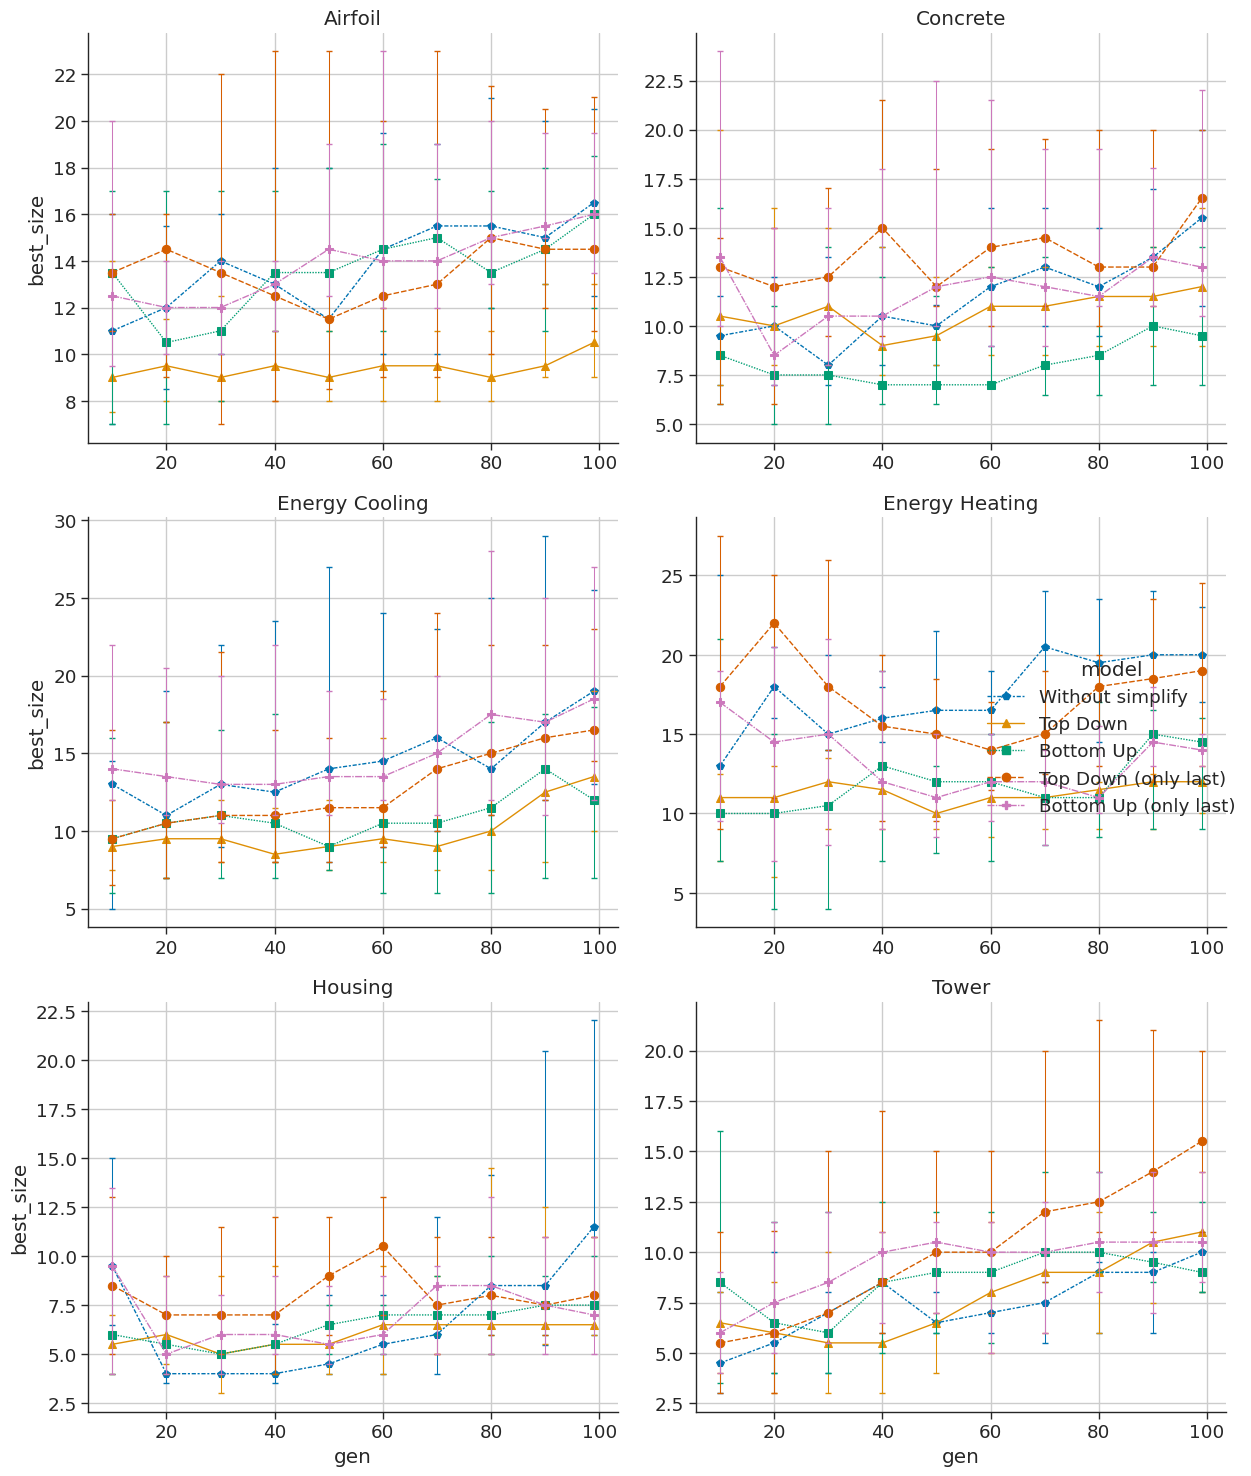

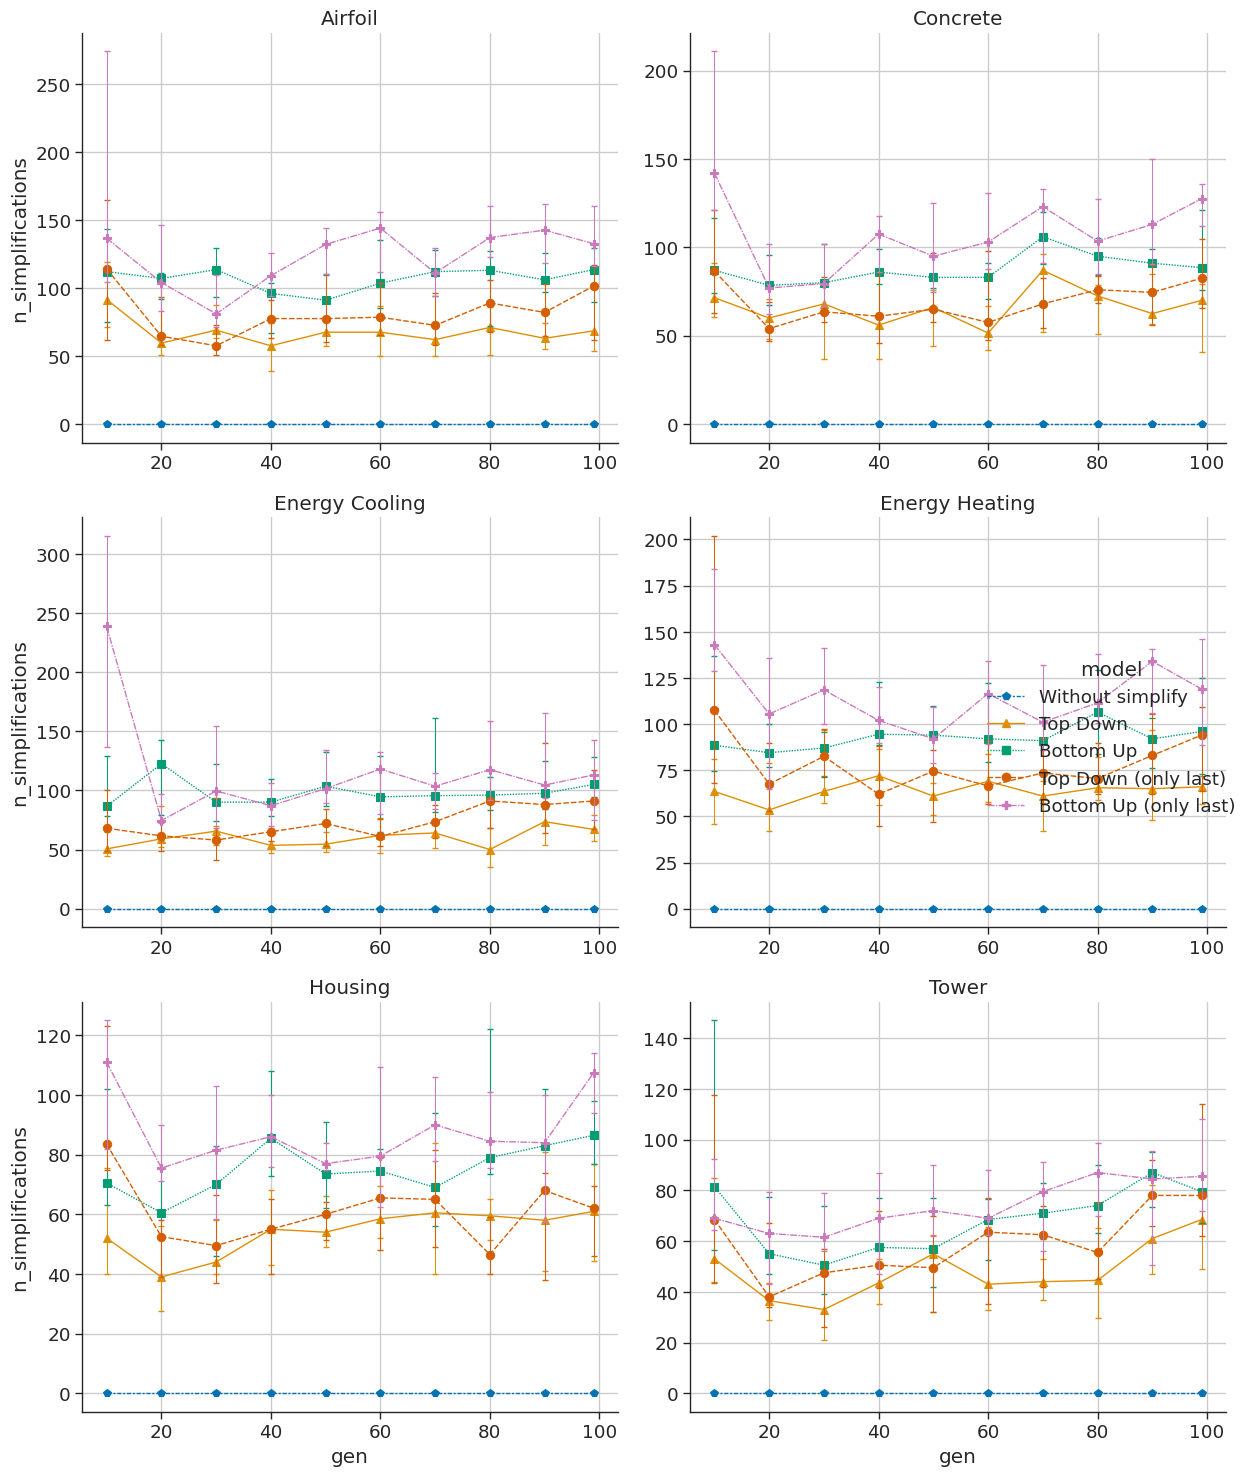

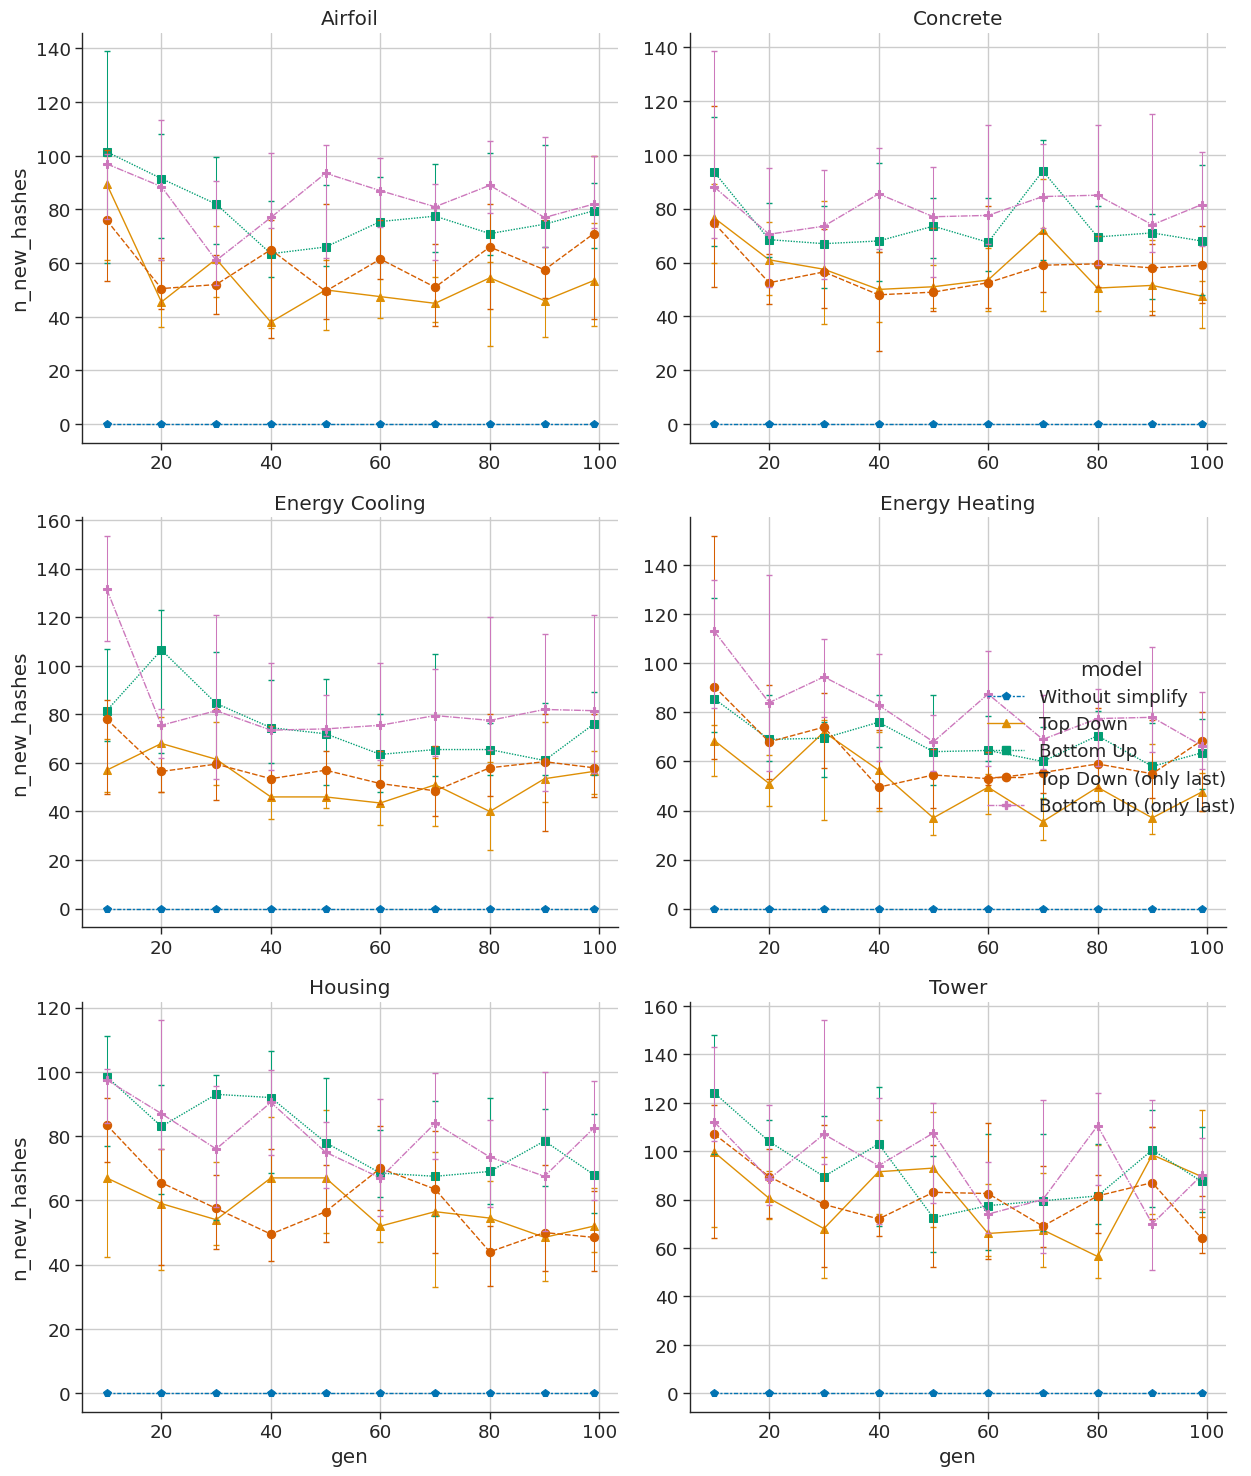

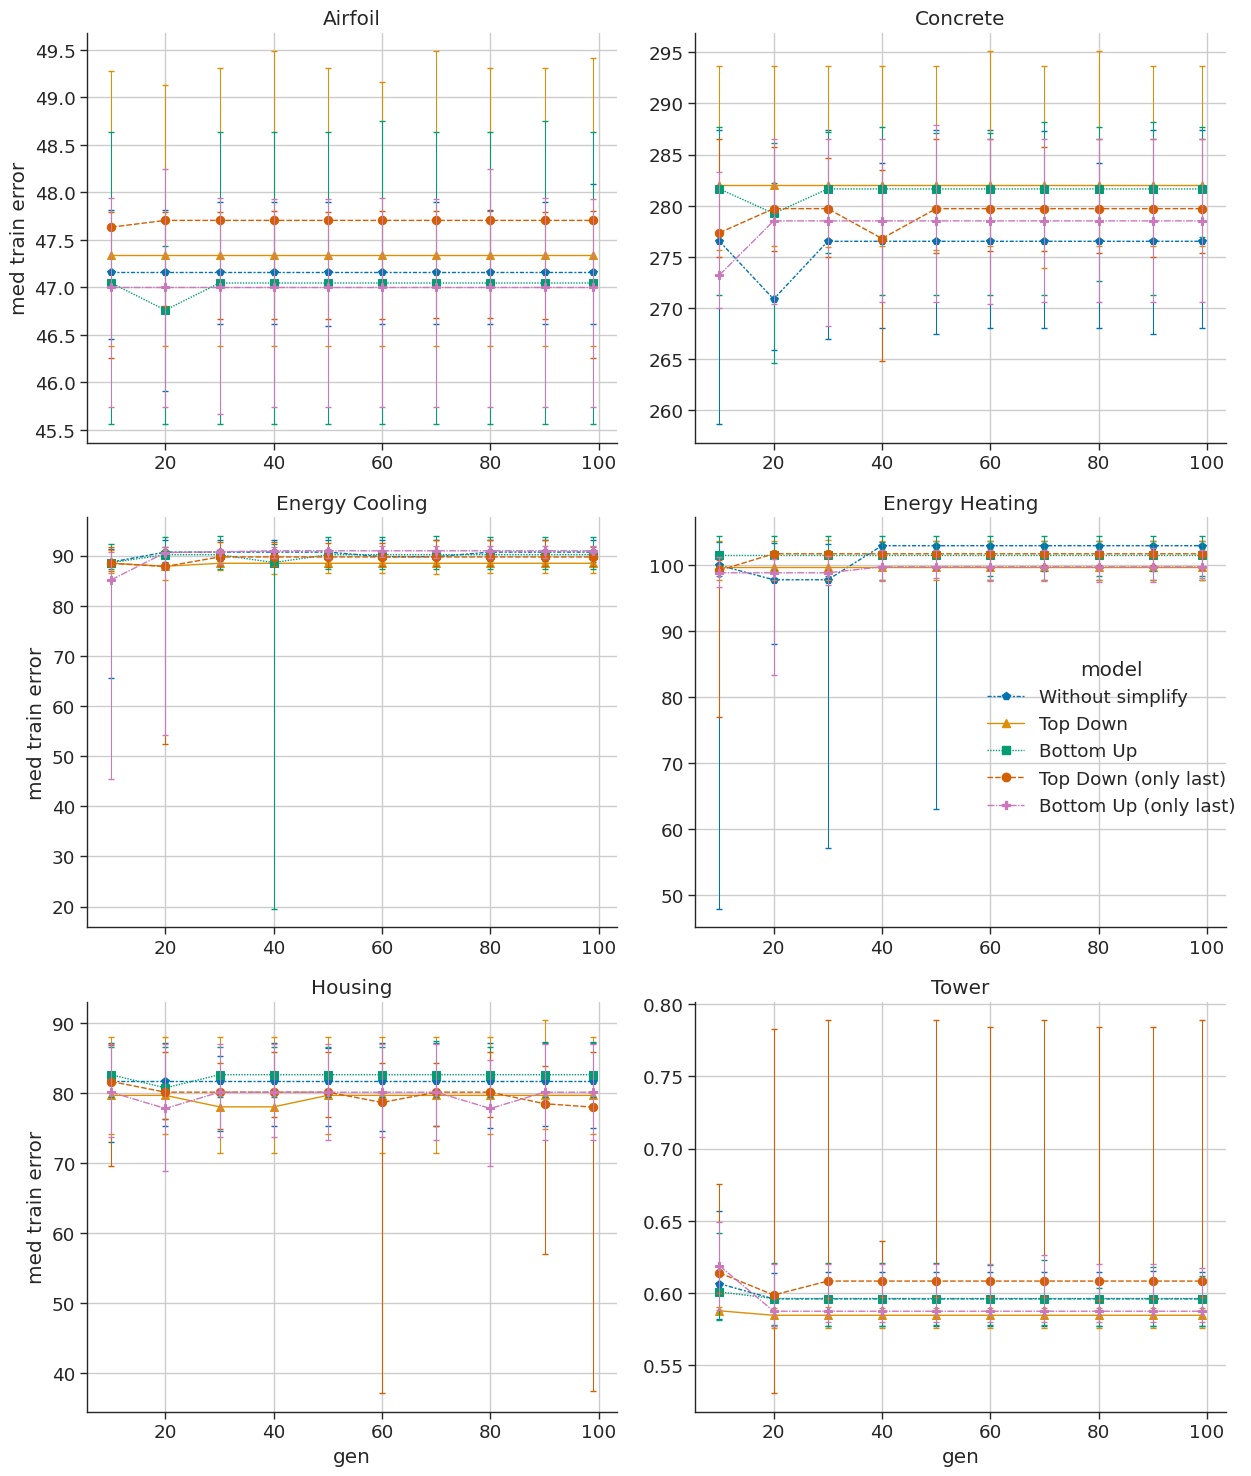

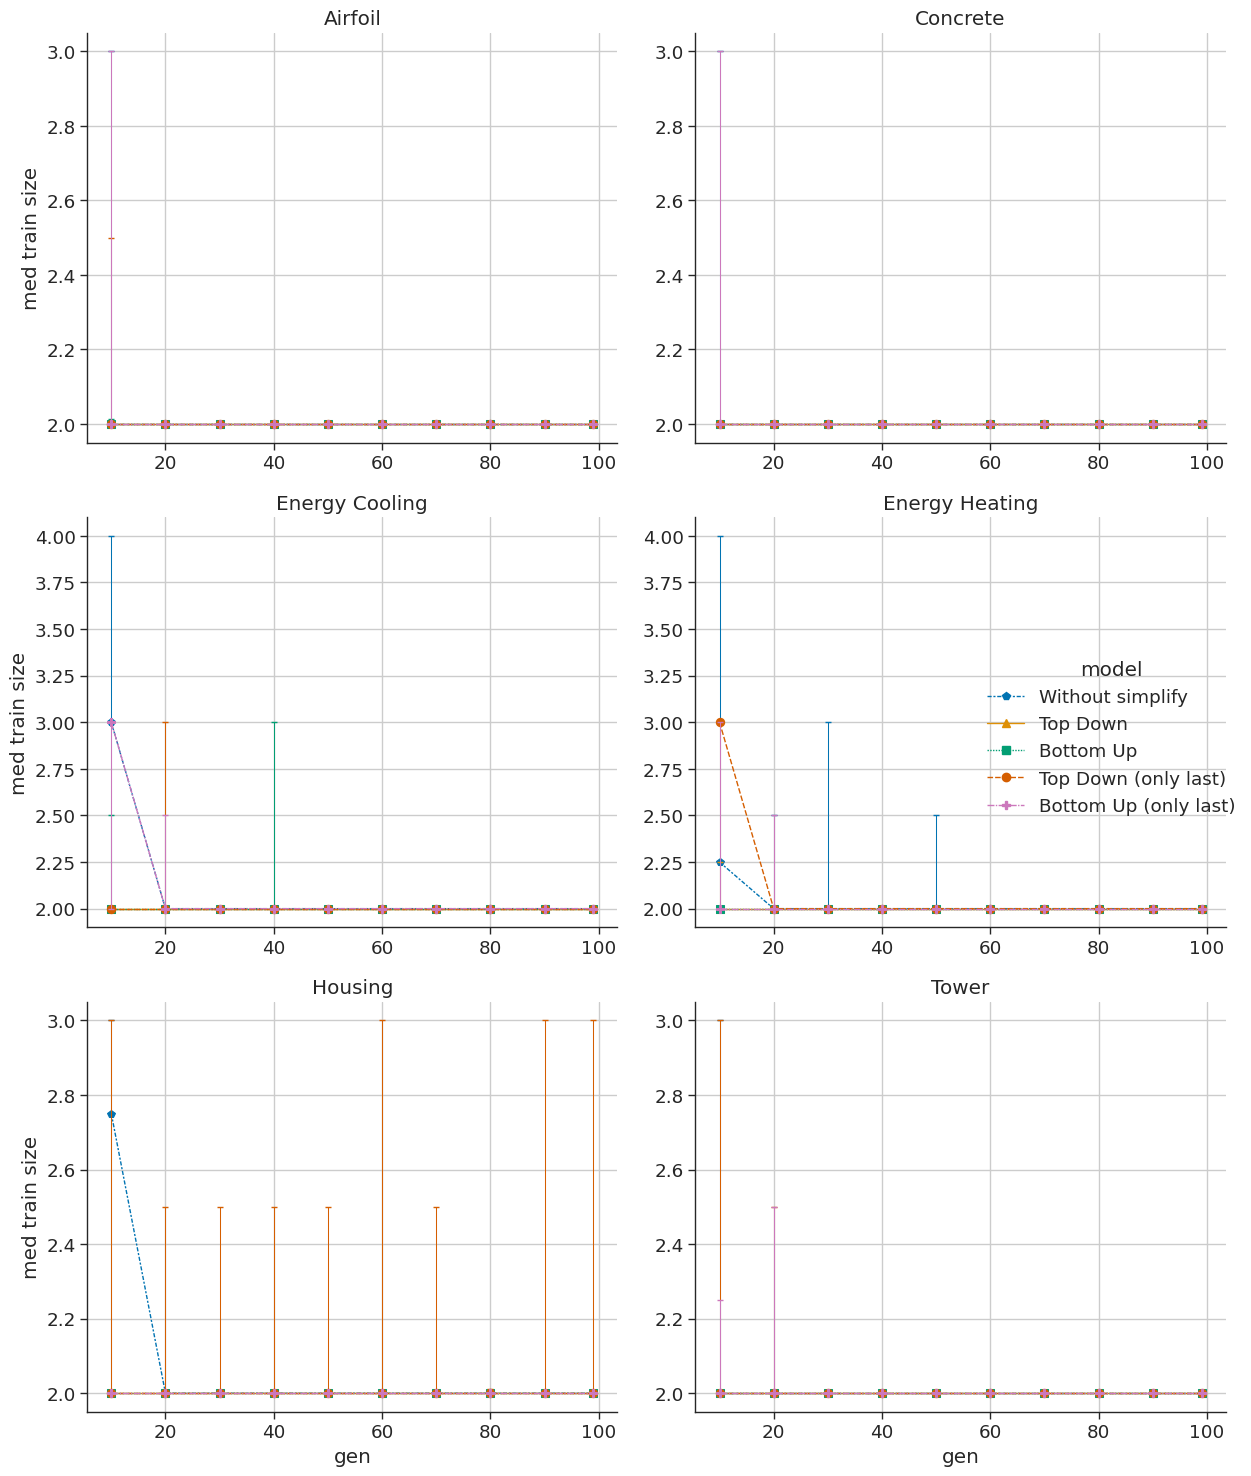

In [3]:
for col in [
    'best_size','n_simplifications','n_new_hashes','med train error','med train size',
    'med val error','med val size','min train error','min val error'
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=col_wrap, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':True}, #errorbar=None, #('ci', 50),
        hue_order = order, estimator=np.median, markersize=6,
        
        err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.75},
        #err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)

    if False: # use log scale
        # g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()